In [80]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string

# Load the data
data = pd.read_csv('British_Airways_Reviews.csv')
reviews = np.array(data['Header'])
labels = np.array(data['Rating'].apply(lambda r : +1 if r >= 5 else 0))


def clean_review(review,my_stopwords,my_lemmatizer):
    # Remove punctuation
    review = review.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    review = re.sub(r'\d+', '', review)
    # Remove multiple spaces
    review = re.sub(r'\s+', ' ', review)
    # Convert to lowercase
    review = review.lower()
    # Remove leading and trailing whitespaces
    review = review.strip()
    words=review.split()
    cleanreview=[w for w in words if not w.lower() in my_stopwords]
    cleanreview = [my_lemmatizer.lemmatize(w) for w in cleanreview]
    cleanreview=" ".join(w for w in cleanreview)
    return cleanreview

my_stopwords = set(stopwords.words('english'))
my_lemmatizer = WordNetLemmatizer()
# Apply the function to the reviews
reviews = [clean_review(review,my_stopwords,my_lemmatizer) for review in reviews]


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1

# Pad the sequences to make them of equal length
max_length = max([len(x) for x in X_train])
X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_val = pad_sequences(X_val, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)


In [81]:
embeddings_size=200
# Use pre-trained embeddings
embeddings_index = {}
f = open('glove.6b.200d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size, embeddings_size))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector




In [82]:
from keras.layers import SpatialDropout1D
from keras.layers import Bidirectional
from keras.optimizers import Adam
# Build the model
model = tf.keras.Sequential()
model.add(Embedding(vocab_size, embeddings_size, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(64, return_sequences=True,recurrent_dropout=0.15))
model.add(Dropout(0.2))
model.add(LSTM(32,recurrent_dropout=0.15))
#model.add(Dense(16))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

#model.add(Bidirectional(LSTM(10, return_sequences=True),
#                             input_shape=(5, 10)))
#model.add(Bidirectional(LSTM(10)))
#model.add(Dense(5))
#model.add(Dropout(0.6))
#model.add(Dense(1, activation='sigmoid'))

# Compile the model
#adam = Adam(learning_rate = 0.0001)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [83]:

# Train the model; The EarlyStopping callback will stop the training if the validation loss does not improve after 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping], epochs=50, batch_size=256)

Epoch 1/50
10/10 [==============================] - 8s 201ms/step - loss: 0.6609 - accuracy: 0.5726 - val_loss: 0.5891 - val_accuracy: 0.6603
Epoch 2/50
10/10 [==============================] - 1s 131ms/step - loss: 0.5495 - accuracy: 0.7731 - val_loss: 0.4036 - val_accuracy: 0.8884
Epoch 3/50
10/10 [==============================] - 1s 129ms/step - loss: 0.3728 - accuracy: 0.8771 - val_loss: 0.2394 - val_accuracy: 0.9216
Epoch 4/50
10/10 [==============================] - 1s 129ms/step - loss: 0.2588 - accuracy: 0.9018 - val_loss: 0.1236 - val_accuracy: 0.9572
Epoch 5/50
10/10 [==============================] - 1s 135ms/step - loss: 0.1675 - accuracy: 0.9409 - val_loss: 0.0504 - val_accuracy: 0.9762
Epoch 6/50
10/10 [==============================] - 1s 130ms/step - loss: 0.1173 - accuracy: 0.9564 - val_loss: 0.0238 - val_accuracy: 0.9881
Epoch 7/50
10/10 [==============================] - 1s 138ms/step - loss: 0.0792 - accuracy: 0.9732 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 

In [84]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

16/16 [==============================] - 0s 11ms/step - loss: 2.0245e-04 - accuracy: 1.0000
Test Loss: 0.0002024545829044655
Test Accuracy: 1.0


In [86]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score

predictions = model.predict(X_test)
#Convert predictions to class labels
predicted_classes = [1 if i>0.5 else 0 for i in predictions]

#Confusion Matrix
conf_mat = confusion_matrix(y_test, predicted_classes)
print(conf_mat)

#Precision, Recall, F1-Score and Support
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, predicted_classes)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1_score)
print("Support: ", support)

#ROC-AUC Score
roc_auc = roc_auc_score(y_test, predictions)
print("ROC-AUC Score: ", roc_auc)

16/16 [==============================] - 1s 16ms/step
[[292   0]
 [  0 203]]
Precision:  [1. 1.]
Recall:  [1. 1.]
F1-Score:  [1. 1.]
Support:  [292 203]
ROC-AUC Score:  1.0


[Text(0.5, 1.0, 'Confusion matrix of an RNN classifier using a test data')]

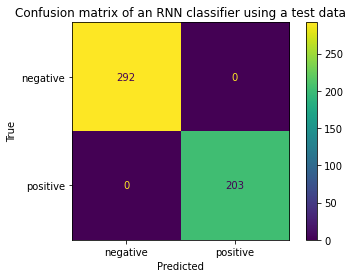

In [109]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_classes)
cmd=ConfusionMatrixDisplay(cm,display_labels=['negative','positive']).plot()

cmd.ax_.set(xlabel='Predicted', ylabel='True')
cmd.ax_.set(title='Confusion matrix of an RNN classifier using a test data')
